In [34]:
import nilearn
from nibabel.testing import data_path
from nilearn import datasets, plotting, regions
import brainspace
import pandas as pd
import numpy as np
import seaborn as sns
import nibabel as nib
import matplotlib.pyplot as plt
from brainspace.utils.parcellation import map_to_labels, reduce_by_labels
from brainspace.gradient.alignment import ProcrustesAlignment
from nilearn import signal
from brainspace.gradient import GradientMaps
from nilearn.maskers import NiftiLabelsMasker
from sklearn.neighbors import NearestNeighbors

from brainspace.datasets import load_conte69, load_parcellation
from brainspace.plotting import plot_hemispheres
surf_lh, surf_rh = load_conte69()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Load Schaefer400 Parcellation & Margulies (2016) grads

In [2]:
schaefer_labels = load_parcellation('schaefer', scale=400, join=True)

In [3]:
marguluies_grads = np.load("/Users/VictoriaShevchenko/Documents/PhD/margulies_grads_32K.npy")

In [4]:
marguluies_grads.shape

(3, 59412)

In [5]:
import hcp_utils as hcp
margulies_grads_labeled = np.array([hcp.cortex_data(i) for i in marguluies_grads])
margulies_grads_labeled.shape

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(3, 64984)

In [6]:
margulies_grads_schaefer400 = reduce_by_labels(margulies_grads_labeled, labels=schaefer_labels)

In [7]:
margulies_grads_schaefer400 = margulies_grads_schaefer400[:, 1:]

# Align & Visualize Group Gradients

In [172]:
scz_group_grads = np.load('clean_data/gradients/SCZ/schaefer400/scz_group_grads.npy').T
control_group_grads = np.load('clean_data/gradients/controls/schaefer400/control_group_grads.npy').T

In [173]:

alignment = ProcrustesAlignment(n_iter = 1000, tol = 0, verbose=True)
SCZGroupGradsAligned = alignment.fit(np.expand_dims(scz_group_grads, axis = 0), margulies_grads_schaefer400.T) # aligning to margulies 2016
scz_group_grads_aligned = np.asarray(SCZGroupGradsAligned.aligned_).squeeze()

ControlGroupGradsAligned = alignment.fit(np.expand_dims(control_group_grads, axis = 0), margulies_grads_schaefer400.T) # aligning to margulies 2016
control_group_grads_aligned = np.asarray(ControlGroupGradsAligned.aligned_).squeeze()


Iteration   0: 3742.817746
Iteration   1: 0.000000
Iteration   2: 0.000000
Iteration   3: 0.000000
Iteration   4: 0.000000
Iteration   5: 0.000000
Iteration   6: 0.000000
Iteration   7: 0.000000
Iteration   8: 0.000000
Iteration   9: 0.000000
Iteration  10: 0.000000
Iteration  11: 0.000000
Iteration  12: 0.000000
Iteration  13: 0.000000
Iteration  14: 0.000000
Iteration  15: 0.000000
Iteration  16: 0.000000
Iteration  17: 0.000000
Iteration  18: 0.000000
Iteration  19: 0.000000
Iteration  20: 0.000000
Iteration  21: 0.000000
Iteration  22: 0.000000
Iteration  23: 0.000000
Iteration  24: 0.000000
Iteration  25: 0.000000
Iteration  26: 0.000000
Iteration  27: 0.000000
Iteration  28: 0.000000
Iteration  29: 0.000000
Iteration  30: 0.000000
Iteration  31: 0.000000
Iteration  32: 0.000000
Iteration  33: 0.000000
Iteration  34: 0.000000
Iteration  35: 0.000000
Iteration  36: 0.000000
Iteration  37: 0.000000
Iteration  38: 0.000000
Iteration  39: 0.000000
Iteration  40: 0.000000
Iteration  41

In [174]:

scz_group_grads_aligned_df = pd.DataFrame(scz_group_grads_aligned, columns = ["Grad 1", "Grad 2", "Grad 3"])
control_group_grads_aligned_df = pd.DataFrame(control_group_grads_aligned, columns = ["Grad 1", "Grad 2", "Grad 3"])
margulies_grads_df = pd.DataFrame(margulies_grads_schaefer400.T, columns = ["Grad 1", "Grad 2", "Grad 3"])


In [175]:
scz_group_grads_aligned_df["Group"] = "SCZ"
control_group_grads_aligned_df["Group"] = "Controls"
margulies_grads_df["Group"] = "Margulies2016"

group_grads_df = pd.concat([scz_group_grads_aligned_df, control_group_grads_aligned_df, margulies_grads_df]).reset_index()


In [148]:
group_grads_df

,index,Grad 1,Grad 2,Grad 3,Group
0,0,-0.863494,3.080749,-0.418061,SCZ
1,1,0.163489,2.025126,-0.856480,SCZ
2,2,-1.247801,3.758898,-0.641826,SCZ
3,3,-1.398836,4.044495,-0.562508,SCZ
4,4,-1.489631,4.183860,-0.624429,SCZ
...,...,...,...,...,...
1195,395,5.737115,-0.011050,-1.823330,Margulies2016
1196,396,5.515594,0.016163,-0.460131,Margulies2016
1197,397,4.141693,-0.208036,0.167758,Margulies2016
1198,398,5.874411,-0.086557,-1.541329,Margulies2016


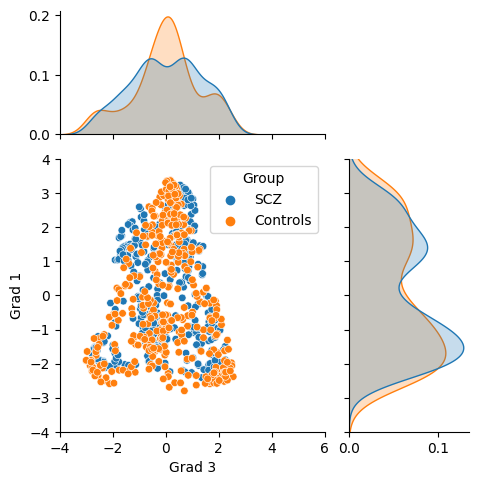

In [176]:
sns.jointplot(data = group_grads_df[group_grads_df["Group"] != "Margulies2016"], x = "Grad 3", y = "Grad 1", hue = "Group", height=5, ratio=2, marginal_ticks=True, s = 30, ylim = (-4, 4), xlim = (-4, 6))
 #, hue = "Grad 1", palette = "viridis"


## Dispersion

In [107]:

n_neighbours = 4
scz_prc_nbrs = NearestNeighbors(n_neighbors=n_neighbours, algorithm='brute').fit(scz_group_grads_aligned)
distances, indices = scz_prc_nbrs.kneighbors(scz_group_grads_aligned)
scz_group_disp = distances.mean(axis = 1)

In [109]:
control_prc_nbrs = NearestNeighbors(n_neighbors=n_neighbours, algorithm='brute').fit(control_group_grads_aligned)
distances, indices = control_prc_nbrs.kneighbors(control_group_grads_aligned)
control_group_disp = distances.mean(axis = 1)

In [151]:
margulies_prc_nbrs = NearestNeighbors(n_neighbors=n_neighbours, algorithm='brute').fit(margulies_grads_schaefer400.T)
distances, indices = margulies_prc_nbrs.kneighbors(margulies_grads_schaefer400.T)
margulies_disp = distances.mean(axis = 1)

In [153]:
group_grads_df["Dispersion"] = np.concatenate([scz_group_disp, control_group_disp, margulies_disp])

In [136]:
min_disp = np.min(group_grads_df["Dispersion"])
max_disp = np.max(group_grads_df["Dispersion"])

In [140]:
np.mean(group_grads_df[group_grads_df["Group"] == "Controls"]["Dispersion"])
np.mean(group_grads_df[group_grads_df["Group"] == "SCZ"]["Dispersion"])

0.20242269254058773

0.19579332980718014

In [142]:
group_grads_df[["Group", "Dispersion"]]

,Group,Dispersion
0,SCZ,0.156171
1,SCZ,0.254923
2,SCZ,0.083950
3,SCZ,0.068083
4,SCZ,0.062626
...,...,...
795,Controls,0.204882
796,Controls,0.099539
797,Controls,0.135072
798,Controls,0.105751


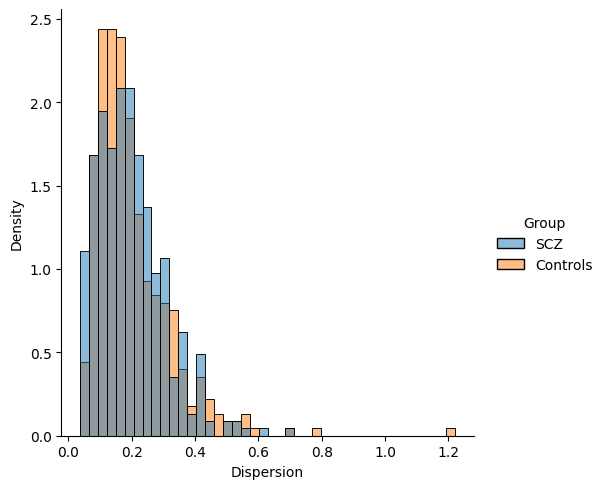

In [156]:
sns.displot(group_grads_df[group_grads_df["Group"] != "Margulies2016"][["Group", "Dispersion"]], x="Dispersion", hue="Group", stat="density")


<Axes: xlabel='Grad 2', ylabel='Grad 1'>

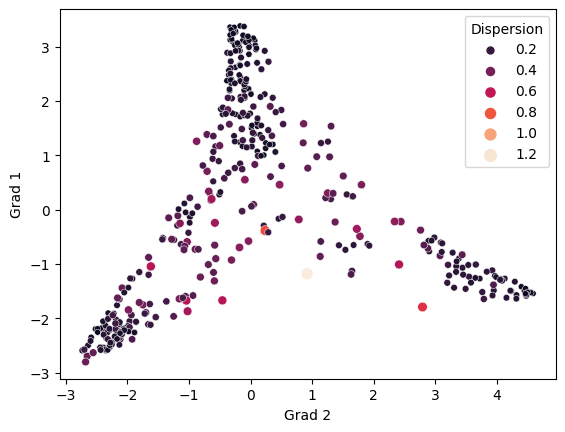

In [137]:
sns.scatterplot(data = group_grads_df[group_grads_df["Group"] == 'Controls'], x = "Grad 2", y = "Grad 1", hue = "Dispersion", size = "Dispersion", palette = "rocket", hue_norm=(min_disp, max_disp))


<Axes: xlabel='Grad 2', ylabel='Grad 1'>

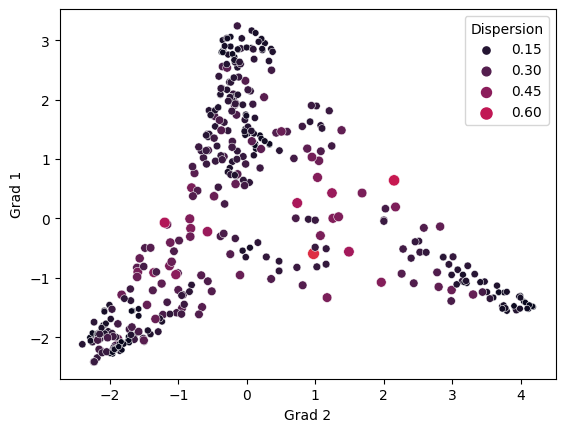

In [138]:
sns.scatterplot(data = group_grads_df[group_grads_df["Group"] == 'SCZ'], x = "Grad 2", y = "Grad 1", hue = "Dispersion", size = "Dispersion", palette = "rocket", hue_norm=(min_disp, max_disp))


# Subject Analyses

## Gradient Alignment (Margulies 2016)

In [163]:
scz_subjects = np.loadtxt("COBRE_SCZ_subjects.txt", dtype = str)[1:]
subjects_grads_paths = [f'clean_data/gradients/SCZ/schaefer400/sub-{subject}/{subject}_gradients.npy' for subject in scz_subjects]
scz_grads = np.asarray([np.load(grad_path).T for grad_path in subjects_grads_paths])

In [164]:
control_subjects = np.loadtxt("COBRE_control_subjects.txt", dtype = str)
subjects_grads_paths = [f'clean_data/gradients/controls/schaefer400/sub-{subject}/{subject}_gradients.npy' for subject in control_subjects]
control_grads = np.asarray([np.load(grad_path).T for grad_path in subjects_grads_paths])

In [178]:
alignment = ProcrustesAlignment(n_iter = 10, tol = 0, verbose=True)
SCZGradsAligned = alignment.fit(scz_grads, margulies_grads_schaefer400.T) # aligning to margulies 2016
scz_grads_aligned = np.asarray(SCZGradsAligned.aligned_)

ControlGradsAligned = alignment.fit(control_grads, margulies_grads_schaefer400.T) # aligning to margulies 2016
control_grads_aligned = np.asarray(ControlGradsAligned.aligned_)


Iteration   0: 4168.457267
Iteration   1: 5.417794
Iteration   2: 1.433170
Iteration   3: 0.139345
Iteration   4: 0.017648
Iteration   5: 0.545787
Iteration   6: 0.026793
Iteration   7: 0.003224
Iteration   8: 0.000417
Iteration   9: 0.000057
Iteration   0: 3744.479083
Iteration   1: 2.332006
Iteration   2: 1.453504
Iteration   3: 0.399306
Iteration   4: 0.017362
Iteration   5: 0.001334
Iteration   6: 0.000115
Iteration   7: 0.000011
Iteration   8: 0.000001
Iteration   9: 0.000000


## Compute Dispersion for all subjects

In [180]:
subject_df_list = []
regions = np.arange(1, 401)
n_neighbours = 4
for subj_grads, subject in zip(scz_grads_aligned, scz_subjects):
    prc_nbrs = NearestNeighbors(n_neighbors=n_neighbours, algorithm='brute').fit(subj_grads)
    distances, indices = prc_nbrs.kneighbors(subj_grads)
    subj_disp = distances.mean(axis = 1)

    subj_df = pd.DataFrame(subj_grads, columns = ["Grad 1", "Grad 2", "Grad 3"])
    subj_df["Subject"] = subject
    subj_df["Group"] = "SCZ"
    subj_df["Region"] = regions
    subj_df["Dispersion"] = subj_disp
    subject_df_list.append(subj_df)



In [181]:
for subj_grads, subject in zip(control_grads_aligned, control_subjects):
    prc_nbrs = NearestNeighbors(n_neighbors=n_neighbours, algorithm='brute').fit(subj_grads)
    distances, indices = prc_nbrs.kneighbors(subj_grads)
    subj_disp = distances.mean(axis = 1)

    subj_df = pd.DataFrame(subj_grads, columns = ["Grad 1", "Grad 2", "Grad 3"])
    subj_df["Subject"] = subject
    subj_df["Group"] = "Controls"
    subj_df["Region"] = regions
    subj_df["Dispersion"] = subj_disp
    subject_df_list.append(subj_df)


In [182]:
data = pd.concat(subject_df_list)

# Permutation T-test

In [189]:
ttest_df = pd.DataFrame(regions, columns = ["Region"])

In [194]:
from scipy.stats import ttest_ind
tstat = []
pval = []
sig = []
for region in regions:
    scz_disp = data[(data["Region"] == region) & (data["Group"] == "SCZ")]["Dispersion"].values
    control_disp = data[(data["Region"] == region) & (data["Group"] == "Controls")]["Dispersion"].values
    t = ttest_ind(scz_disp, control_disp, equal_var = False, permutations = 10000)
    tstat.append(t.statistic)
    pval.append(t.pvalue)
    if t.pvalue <= 0.05:
        sig.append(True)
    else:
        sig.append(False)
    

In [195]:
ttest_df["Statistic"] = tstat
ttest_df["p-value"] = pval
ttest_df["Sig"] = sig

In [259]:
sig_regions = ttest_df["Sig"].values
sig_regions = map_to_labels(sig_regions, schaefer_labels, mask=schaefer_labels != 0, fill=np.nan)

control_1grad_aligned_vis = map_to_labels(control_group_grads_aligned[:, 0], schaefer_labels, mask=schaefer_labels != 0, fill=np.nan)

In [316]:
from neuromaps.datasets import fetch_fslr
from surfplot import Plot
from brainspace.datasets import load_parcellation

surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
lh_parc, rh_parc = load_parcellation('schaefer')

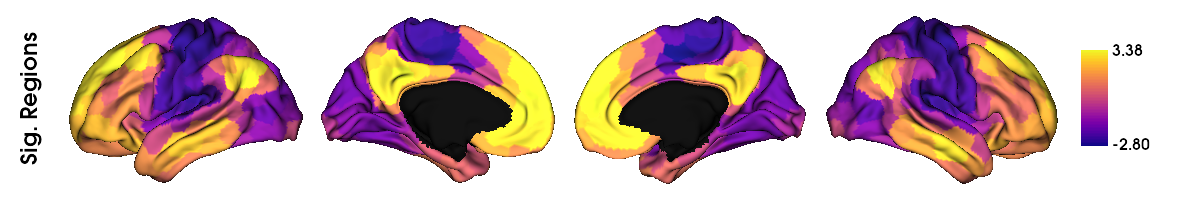

In [250]:
plot_hemispheres(surf_lh, surf_rh, array_name=control_1grad_aligned_vis, size=(1200, 200), cmap='plasma',
                 color_bar=True, label_text=['Sig. Regions'], zoom=1.5, embed_nb = True)

In [318]:
sig_region_effect = np.zeros((400))
sig_region_effect[:] = np.nan
sig_region_effect[sig_regions == True]  = ttest_df["Statistic"].values[sig_regions == True]

In [302]:
sig_region_effect_vis = map_to_labels(sig_region_effect, schaefer_labels, mask=schaefer_labels != 0, fill=np.nan)

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_86094/417269556.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


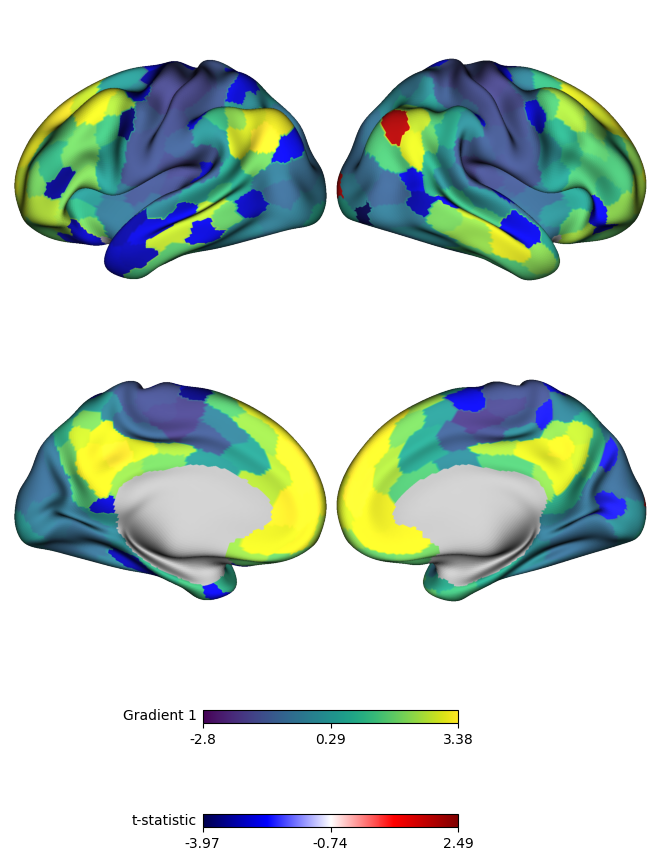

In [335]:
result_t = Plot(lh, rh,  size=(1000, 1000), zoom = 1.25)

result_t.add_layer({'left': control_1grad_aligned_vis[:32492], 'right': control_1grad_aligned_vis[32492:]}, cbar=True, cmap = "viridis", cbar_label= "Gradient 1")
result_t.add_layer({'left': sig_region_effect_vis[:32492], 'right': sig_region_effect_vis[32492:]}, as_outline= False, cmap='seismic', cbar=True, cbar_label="t-statistic")

fig = result_t.build(scale = (2, 2))
fig.show()
#result_t.show(embed_nb = True, scale=(10, 10))